In [1]:
import numpy as np
import sympy as sp
from scipy.spatial import ConvexHull

import random
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as Poly
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon, LineString, Point
from itertools import combinations

In [2]:
class MyPoly:
    def __init__(self, data):
        self.points = np.array(data)

    def __repr__(self):
        f'Список точек {tuple([tuple(i) for i in self.points])}'

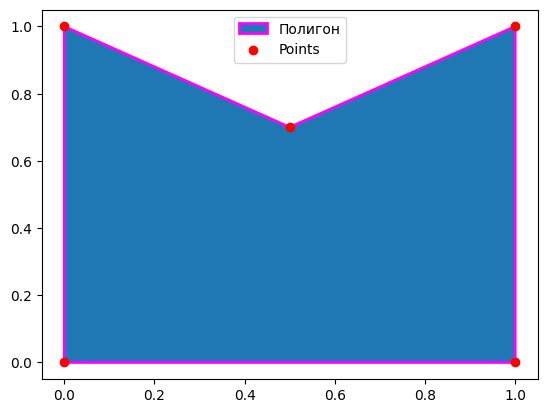

In [3]:
poly = MyPoly([[0, 0],[1, 0], [1, 1], [0.5, 0.7], [0, 1]])
fig, ax = plt.subplots()
ax.add_patch(Poly(poly.points, closed=True, fill=True, edgecolor='magenta', linewidth=2, label='Полигон'))
ax.scatter(poly.points[:, 0], poly.points[:, 1], color='red', label='Points')
ax.legend()
plt.show()

# 1

*ТРИАНГУЛЯЦИЯ ПОЛИГОНА*

In [4]:
def is_point_in_triangle(q, p1, p2, p3):
    """Проверяет, находится ли точка q внутри треугольника p1p2p3."""
    q = np.array(q)
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    V = p2-p1
    W = p3-p1
    t, f = sp.Matrix([(q-p1)@V, (q-p1)@W]).T @ sp.Matrix([[V@V, V@W], [V@W, W@W]]).inv()

    # eckb gjl[jlbn ]
    if 0 <= t <= 1 and 0 <= f <= 1 and t + f <= 1:
        return True
    return False

## 1.2

Спроектируйте и реализуйте триангуляцию простого невыпуклого полигона
методом диагоналей.

In [5]:
def triangulate_polygon_diag(vertices):
    """Триангулирует многоугольник, заданный списком вершин."""
    vertices = list(vertices)
    def is_ear(i, vertices):
        p1 = vertices[i - 1]
        p2 = vertices[i]
        p3 = vertices[(i + 1) % len(vertices)]

        polygon = Polygon(vertices)
        triangle = Polygon([p1, p2, p3])
        if not polygon.contains(triangle):
            return False
        
        # Проверяем, является ли треугольник p1p2p3 "ухом" (треугольником который можно вырезать)
        for j in range(len(vertices)):
            if j == i or j == (i - 1) or j == (i + 1) % len(vertices):
                continue
            if is_point_in_triangle(vertices[j], p1, p2, p3):
                return False
        return True

    triangles = []

    while len(vertices) > 3:
        for i in range(len(vertices)):
            if is_ear(i, vertices):
                p1 = vertices[i - 1]
                p2 = vertices[i]
                p3 = vertices[(i + 1) % len(vertices)]
                triangles.append((p1, p2, p3))
                vertices.pop(i)
                break

    # Добавляем последний треугольник
    triangles.append(tuple(vertices))
    return triangles

In [6]:
triangles = triangulate_polygon_diag(poly.points)
triangles

[(array([0., 0.]), array([1., 0.]), array([1., 1.])),
 (array([0., 0.]), array([1., 1.]), array([0.5, 0.7])),
 (array([0., 0.]), array([0.5, 0.7]), array([0., 1.]))]

## 1.2

*Спроектируйте и реализуйте триангуляцию простого невыпуклого полигона
методом хорд*

In [7]:
def triangulate_polygon_chords(vertices):
    """Триангулирует многоугольник, заданный списком вершин, с использованием хорд."""
    def is_point_in_triangle(pt, v1, v2, v3):
        """Проверяет, находится ли точка внутри треугольника."""
        def sign(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

        b1 = sign(pt, v1, v2) < 0.0
        b2 = sign(pt, v2, v3) < 0.0
        b3 = sign(pt, v3, v1) < 0.0

        return b1 == b2 == b3

    def is_chord_valid(v1_idx, v2_idx, vertices):
        if abs(v1_idx - v2_idx) == 1 or abs(v1_idx - v2_idx) == len(vertices) - 1:
            return False  # Это смежные вершины, а не хорда

        v1, v2 = vertices[v1_idx], vertices[v2_idx]
        # Проверяем, что хорда не пересекает стороны многоугольника
        for i in range(len(vertices)):
            v3, v4 = vertices[i], vertices[(i + 1) % len(vertices)]
            if not np.array_equal(v3, v1) and not np.array_equal(v3, v2) and \
               not np.array_equal(v4, v1) and not np.array_equal(v4, v2):
                if segments_intersect(v1, v2, v3, v4):
                    return False
        polygon = Polygon(vertices)
        mid_point = Point((v1[0] + v2[0]) / 2, (v1[1] + v2[1]) / 2)
        if polygon.contains(mid_point):
            return True
        else:
            return False

    def segments_intersect(p1, p2, q1, q2):
        """Проверяет, пересекаются ли отрезки p1p2 и q1q2."""
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    def split_polygon(vertices, v1_idx, v2_idx):
        if v1_idx > v2_idx:
            v1_idx, v2_idx = v2_idx, v1_idx

        part1 = vertices[v1_idx:v2_idx + 1]
        part2 = np.concatenate((vertices[v2_idx:], vertices[:v1_idx + 1]), axis=0)
        return part1, part2

    def recursive_triangulation(vertices):
        if len(vertices) == 3:
            return [tuple(map(tuple, vertices))]

        for i in range(len(vertices)):
            for j in range((i + 1) % len(vertices),  len(vertices)):
                if is_chord_valid(i, j, vertices):
                    part1, part2 = split_polygon(vertices, i, j)
                    # print(part1, part2, sep='\n %')
                    return (recursive_triangulation(part1) +
                            recursive_triangulation(part2))

    return recursive_triangulation(vertices)

In [8]:
triangles1 = triangulate_polygon_chords(poly.points)
print("Триангуляция:", triangles1)

Триангуляция: [((0.0, 0.0), (1.0, 0.0), (1.0, 1.0)), ((0.5, 0.7), (0.0, 1.0), (0.0, 0.0)), ((0.0, 0.0), (1.0, 1.0), (0.5, 0.7))]


In [9]:
import matplotlib.cm as cm
from matplotlib import patches

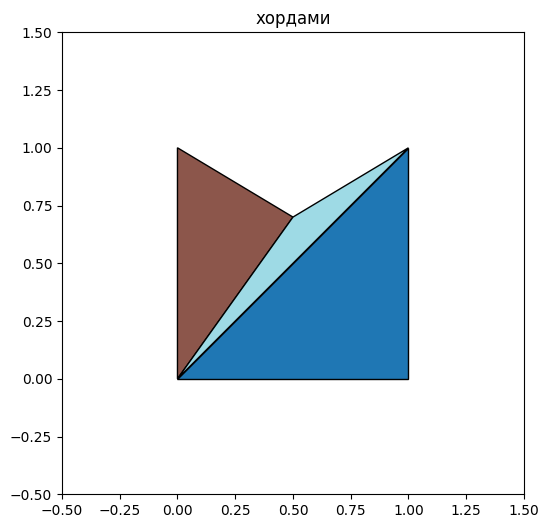

In [10]:
plt.figure(figsize=(6, 6))

num_triangles = len(triangles)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles1, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles for point in triangle]
all_y = [point[1] for triangle in triangles for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.title("хордами")
plt.show()

[(array([0., 0.]), array([1., 0.]), array([1., 1.])), (array([0., 0.]), array([1., 1.]), array([0.5, 0.7])), (array([0., 0.]), array([0.5, 0.7]), array([0., 1.]))]


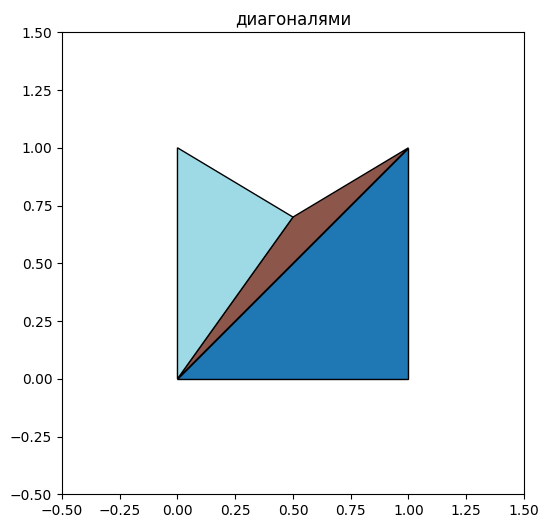

In [11]:
triangles1 = triangulate_polygon_diag(poly.points)
print(triangles1)
plt.figure(figsize=(6, 6))

num_triangles = len(triangles)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles1, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles for point in triangle]
all_y = [point[1] for triangle in triangles for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.title("диагоналями")
plt.show()

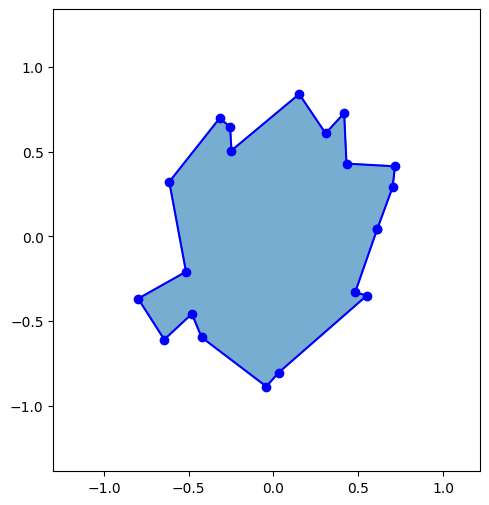

In [39]:
import random

def generate_random_polygon(n_vertices, center=(0, 0), radius=1.0):
    cx, cy = center
    angles = sorted(random.uniform(0, 2 * np.pi) for _ in range(n_vertices))
    vertices = [
        (cx + radius * random.uniform(0.5, 1.0) * np.cos(angle), cy + radius * random.uniform(0.5, 1.0) * np.sin(angle))
        for angle in angles
    ]
    return vertices

random_polygon = generate_random_polygon(20)

plt.figure(figsize=(6, 6))
polygon_patch = patches.Polygon(random_polygon, closed=True, alpha=0.6, edgecolor='black')
plt.gca().add_patch(polygon_patch)

x_coords, y_coords = zip(*random_polygon)
plt.plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), marker='o', color='blue') 
plt.xlim(min(x_coords) - 0.5, max(x_coords) + 0.5)
plt.ylim(min(y_coords) - 0.5, max(y_coords) + 0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [40]:
random_polygon = np.array(random_polygon)

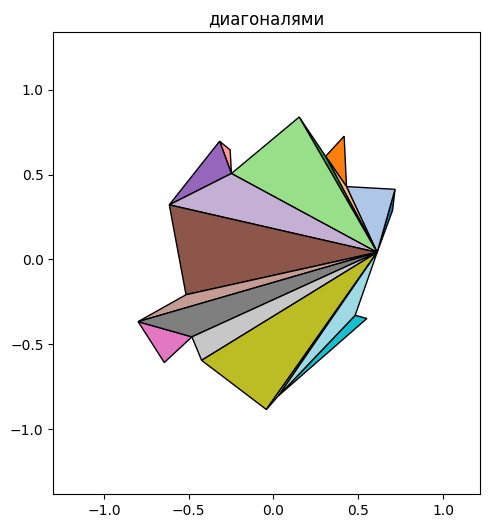

In [41]:
triangles2 = triangulate_polygon_diag(random_polygon)
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.title("диагоналями")
plt.show()

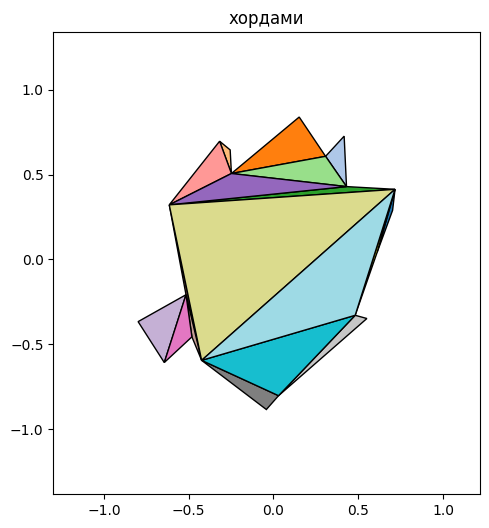

In [42]:
triangles2 = triangulate_polygon_chords(random_polygon)
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.title("хордами")
plt.show()

## 2

In [43]:
def segments_intersect(p1, p2, q1, q2):
    def orientation(a, b, c):
        val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
        if np.isclose(val, 0):
            return 0
        return 1 if val > 0 else 2

    def on_segment(a, b, c):
        # Проверяет, лежит ли точка b на отрезке a-c
        return (
            min(a[0], c[0]) <= b[0] <= max(a[0], c[0]) and
            min(a[1], c[1]) <= b[1] <= max(a[1], c[1])
        )

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    # Общие случаи пересечения
    if o1 != o2 and o3 != o4:
        return True

    # Проверки на коллинеарность
    if o1 == 0 and on_segment(p1, q1, p2):
        return True
    if o2 == 0 and on_segment(p1, q2, p2):
        return True
    if o3 == 0 and on_segment(q1, p1, q2):
        return True
    if o4 == 0 and on_segment(q1, p2, q2):
        return True

    return False

def greedy_triangulation(points):
    edges = []
    for (i, j) in combinations(range(len(points)), 2):
        # Исключаем смежные точки
        if abs(i - j) == 1 or (i == 0 and j == len(points) - 1):
            continue
        dist = np.linalg.norm(points[i] - points[j])
        edges.append((dist, i, j))
    edges.sort()

    triangulation = []
    polygon = Polygon(points)

    # Добавляем отрезки в триангуляцию, если они не пересекаются (разрешаем пересечение в вершинах)
    for _, i, j in edges:
        new_edge = (points[i], points[j])
        line = LineString(new_edge)
        # Проверяем, находится ли отрезок внутри полигона
        if polygon.contains(line):
            if all(not segments_intersect(new_edge[0], new_edge[1], edge[0], edge[1]) or \
                   np.array_equal(new_edge[0], edge[0]) or np.array_equal(new_edge[0], edge[1]) or \
                   np.array_equal(new_edge[1], edge[0]) or np.array_equal(new_edge[1], edge[1]) \
                   for edge in triangulation):
                triangulation.append(new_edge)

    return triangulation

In [44]:
greedy_triangulation(poly.points)

[(array([0., 0.]), array([0.5, 0.7])), (array([1., 0.]), array([0.5, 0.7]))]

In [45]:
def plot_polygon_and_segments(polygon_points, segments):
    polygon = Polygon(polygon_points)
    line_segments = [LineString([Point(start), Point(end)]) for start, end in segments]
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.fill(x, y, alpha=0.5, color='blue', label='Polygon')
    for line in line_segments:
        x, y = line.xy
        ax.plot(x, y, color='red', linewidth=2, label='Segment')
    ax.set_aspect('equal')
    plt.show()

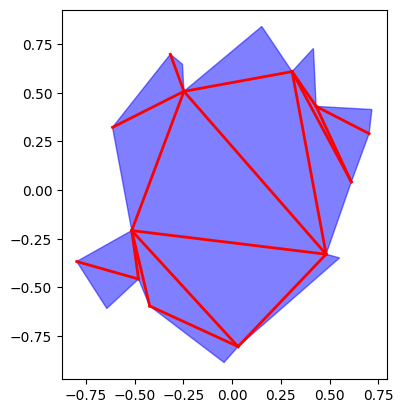

In [46]:
plot_polygon_and_segments(random_polygon, greedy_triangulation(random_polygon))

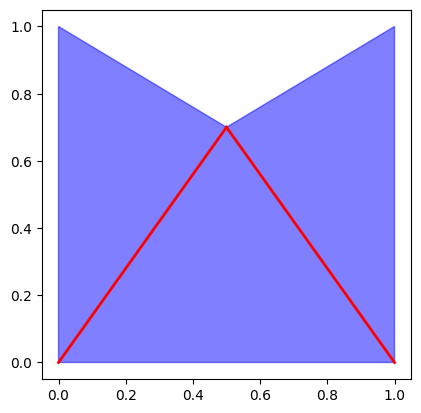

In [47]:
plot_polygon_and_segments(poly.points, greedy_triangulation(poly.points))

### 2.2

In [48]:
import time
import timeit

In [49]:
def measure_time(func, *args):
    start_time = time.time()
    func(*args)
    return time.time() - start_time

In [50]:
greedy_time = measure_time(greedy_triangulation, random_polygon)
chords_time = measure_time(triangulate_polygon_chords, random_polygon)
diag_time = measure_time(triangulate_polygon_diag, random_polygon)

In [51]:
# Для встроенной библиотеки, например, scipy для триангуляции
import scipy.spatial

In [52]:
def scipy_triangulation(points):
    scipy.spatial.Delaunay(points)

In [53]:
scipy_time = measure_time(scipy_triangulation, random_polygon)

In [54]:
print(f"Жадный: {greedy_time:.6f} сек")
print(f"Хордами: {chords_time:.6f} сек")
print(f"Диагоналями: {diag_time:.6f} сек")
print(f"Встройка: {scipy_time:.6f} сек")

Жадный: 0.088260 сек
Хордами: 0.004534 сек
Диагоналями: 0.376336 сек
Встройка: 0.016545 сек


# 3

**Общий проект**

без кэша

In [55]:
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

class Delone:
    def __init__(self):
        self.points = []  # Список вершин
        self.triangles = []  # Список треугольников

    def add_point(self, new_point):
        """
        Добавляет точку в список и обновляет триангуляцию Делоне.
        """
        self.points.append(new_point)
        
        # Перестраиваем триангуляцию с новой точкой
        self._retriangulate()

    def _retriangulate(self):
        """
        Перестраивает триангуляцию Делоне с учетом новой точки.
        """
        if len(self.points) < 3:
            return  # Невозможно построить треугольники с менее чем 3 точками

        self.triangles = []  # Очистить старые треугольники

        # Пройти по всем возможным треугольникам и проверять условие Делоне
        for i, p1 in enumerate(self.points):
            for j, p2 in enumerate(self.points):
                if j <= i:
                    continue
                for k, p3 in enumerate(self.points):
                    if k <= j:
                        continue

                    # Проверяем, выполняется ли условие Делоне
                    if self._is_delaunay_triangle(p1, p2, p3):
                        if Polygon(self.points).contains(Polygon(np.array([p1, p2, p3]))):
                            self.triangles.append((p1, p2, p3))

    def _is_delaunay_triangle(self, p1, p2, p3):
        """
        Проверяет, выполняется ли условие Делоне для треугольника (p1, p2, p3).
        """
        # Найти центр и радиус описанной окружности треугольника
        circle_center, radius = self._circumcircle(p1, p2, p3)

        # Проверить, есть ли точки внутри окружности
        for p in self.points:
            if p in [p1, p2, p3]:
                continue

            # Если точка внутри окружности, возвращаем False
            if np.linalg.norm(np.array(p) - np.array(circle_center)) < radius:
                return False

        return True

    def _circumcircle(self, p1, p2, p3):
        """
        Вычисляет центр и радиус описанной окружности треугольника (p1, p2, p3).
        """
        ax, ay = p1
        bx, by = p2
        cx, cy = p3

        # Вычислить определители
        d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
        if d == 0:
            return None, None  # Точки лежат на одной прямой

        # Найти центр окружности
        ux = ((ax**2 + ay**2) * (by - cy) + (bx**2 + by**2) * (cy - ay) + (cx**2 + cy**2) * (ay - by)) / d
        uy = ((ax**2 + ay**2) * (cx - bx) + (bx**2 + by**2) * (ax - cx) + (cx**2 + cy**2) * (bx - ax)) / d

        center = (ux, uy)
        radius = np.sqrt((ux - ax)**2 + (uy - ay)**2)

        return center, radius

In [56]:
points = np.array([[0, 0], [1, 0], [1, 1], [0.5, 0.7], [0, 1]])
triangulator1 = Delone()

for point in points:
    triangulator1.add_point(tuple(point))
    print(triangulator1.points)

print("Треугольники:", triangulator1.triangles)

[(0.0, 0.0)]
[(0.0, 0.0), (1.0, 0.0)]
[(0.0, 0.0), (1.0, 0.0), (1.0, 1.0)]
[(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.5, 0.7)]
[(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.5, 0.7), (0.0, 1.0)]
Треугольники: [((0.0, 0.0), (1.0, 0.0), (0.5, 0.7)), ((0.0, 0.0), (0.5, 0.7), (0.0, 1.0)), ((1.0, 0.0), (1.0, 1.0), (0.5, 0.7))]


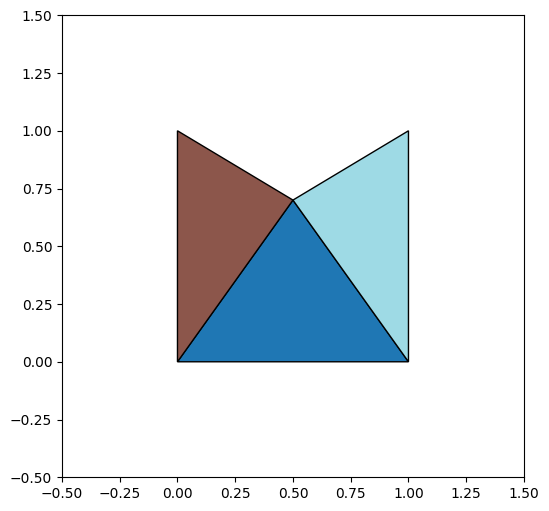

In [57]:
triangles2 = triangulator1.triangles
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.show()

In [58]:
triangulator2 = Delone()

for point in random_polygon:
    triangulator2.add_point(tuple(point))
    # print(triangulator2.points)

print("Треугольники:", triangulator2.triangles)

Треугольники: [((0.6118016059199116, 0.041785810737190794), (0.7030396452005186, 0.2898329394816675), (0.43112943173078716, 0.429819076182329)), ((0.6118016059199116, 0.041785810737190794), (0.43112943173078716, 0.429819076182329), (0.48235357058686784, -0.3293442650161905)), ((0.7030396452005186, 0.2898329394816675), (0.7174640179081649, 0.4137364352321612), (0.43112943173078716, 0.429819076182329)), ((0.43112943173078716, 0.429819076182329), (0.41728785103854493, 0.7273922670110726), (0.30773142597751313, 0.6083700607274468)), ((0.43112943173078716, 0.429819076182329), (0.30773142597751313, 0.6083700607274468), (-0.24771490606724395, 0.5069934338757739)), ((0.43112943173078716, 0.429819076182329), (-0.24771490606724395, 0.5069934338757739), (0.48235357058686784, -0.3293442650161905)), ((0.30773142597751313, 0.6083700607274468), (0.15207819101646056, 0.8401125809565557), (-0.24771490606724395, 0.5069934338757739)), ((-0.24771490606724395, 0.5069934338757739), (-0.2551281354070471, 0.6

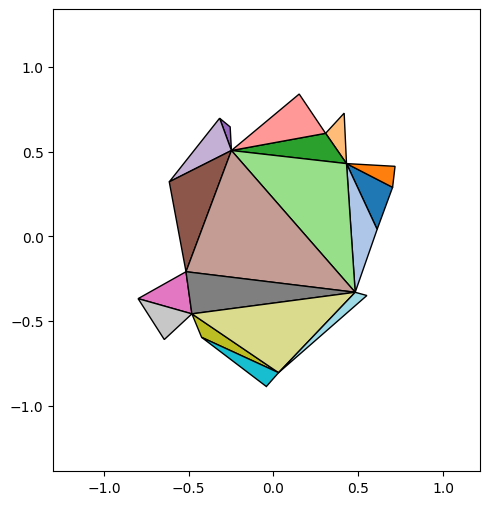

In [59]:
triangles2 = triangulator2.triangles
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.show()

с кэшэм

In [113]:
class Delone_with_cash2:
    def __init__(self, cache_size=2):
        self.points = []  # Список вершин
        self.triangles = []  # Список треугольников
        self.cache = []  # Динамический кэш треугольников
        self.cache_size = cache_size  # Начальный размер кэша
        self.cache_bounds = None  # Границы кэша
        self.polygon = None  # Полигон, образованный исходными точками

    def add_point(self, new_point):
        """
        Добавляет точку в список и обновляет триангуляцию Делоне.
        """
        self.points.append(new_point)

        # Обновляем полигон, если точек достаточно
        if len(self.points) >= 3:
            self.polygon = Polygon(self.points)

        # Увеличить кэш, если новая точка выходит за его границы
        if not self._point_in_cache(new_point):
            self._resize_cache(new_point)

        # Обновить триангуляцию в рамках кэша
        self._retriangulate()

    def _point_in_cache(self, point):
        """
        Проверяет, находится ли точка внутри текущего кэша.
        """
        if self.cache_bounds is None:
            return False
        x, y = point
        x_min, y_min, x_max, y_max = self.cache_bounds
        return x_min <= x <= x_max and y_min <= y <= y_max

    def _resize_cache(self, new_point):
        """
        Увеличивает размер кэша и обновляет его границы.
        """
        if self.cache_bounds is None:
            x, y = new_point
            self.cache_bounds = [x - self.cache_size, y - self.cache_size, 
                                 x + self.cache_size, y + self.cache_size]
        else:
            x, y = new_point
            x_min, y_min, x_max, y_max = self.cache_bounds
            self.cache_bounds = [
                min(x_min, x - self.cache_size),
                min(y_min, y - self.cache_size),
                max(x_max, x + self.cache_size),
                max(y_max, y + self.cache_size),
            ]

    # Обновляем список точек в кэше
        self.cache = [
            point for point in self.points if self._point_in_cache(point)
        ]

        # print(f"Кэш обновлён: {self.cache_bounds}")
        # print(f"Точки в кэше: {self.cache}")

    def _retriangulate(self):
        """
        Перестраивает триангуляцию Делоне в рамках кэша.
        """
        if len(self.points) < 3:
            return  # Невозможно построить треугольники с менее чем 3 точками

        self.triangles = []  # Очистить старые треугольники
        x_min, y_min, x_max, y_max = self.cache_bounds

        # Пройти по всем возможным треугольникам в кэше
        for i, p1 in enumerate(self.points):
            if not self._point_in_cache(p1):
                continue
            for j, p2 in enumerate(self.points):
                if j <= i or not self._point_in_cache(p2):
                    continue
                for k, p3 in enumerate(self.points):
                    if k <= j or not self._point_in_cache(p3):
                        continue

                    # Проверяем, выполняется ли условие Делоне
                    if self._is_delaunay_triangle(p1, p2, p3):
                        # Проверяем, лежит ли треугольник внутри полигона
                        if self.polygon is not None:
                            triangle_polygon = Polygon([p1, p2, p3])
                            if not self.polygon.contains(triangle_polygon):
                                continue  # Пропускаем треугольники вне полигона

                        self.triangles.append((p1, p2, p3))

    def _is_delaunay_triangle(self, p1, p2, p3):
        """
        Проверяет, выполняется ли условие Делоне для треугольника (p1, p2, p3).
        """
        # Найти центр и радиус описанной окружности треугольника
        circle_center, radius = self._circumcircle(p1, p2, p3)

        # Проверить, есть ли точки внутри окружности
        for p in self.points:
            if p in [p1, p2, p3]:
                continue

            # Если точка внутри окружности, возвращаем False
            if np.linalg.norm(np.array(p) - np.array(circle_center)) < radius:
                return False

        return True

    def _circumcircle(self, p1, p2, p3):
        """
        Вычисляет центр и радиус описанной окружности треугольника (p1, p2, p3).
        """
        ax, ay = p1
        bx, by = p2
        cx, cy = p3

        # Вычислить определители
        d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
        if d == 0:
            return None, None  # Точки лежат на одной прямой

        # Найти центр окружности
        ux = ((ax**2 + ay**2) * (by - cy) + (bx**2 + by**2) * (cy - ay) + (cx**2 + cy**2) * (ay - by)) / d
        uy = ((ax**2 + ay**2) * (cx - bx) + (bx**2 + by**2) * (ax - cx) + (cx**2 + cy**2) * (bx - ax)) / d

        center = (ux, uy)
        radius = np.sqrt((ux - ax)**2 + (uy - ay)**2)

        return center, radius


[(0.0, 0.0)]
[(0.0, 0.0), (1.0, 0.0)]
[(0.0, 0.0), (1.0, 0.0), (1.0, 1.0)]
[(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.5, 0.7)]
[(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.5, 0.7), (0.0, 1.0)]
Треугольник: ((0.0, 0.0), (1.0, 0.0), (0.5, 0.7))
Треугольник: ((0.0, 0.0), (0.5, 0.7), (0.0, 1.0))
Треугольник: ((1.0, 0.0), (1.0, 1.0), (0.5, 0.7))


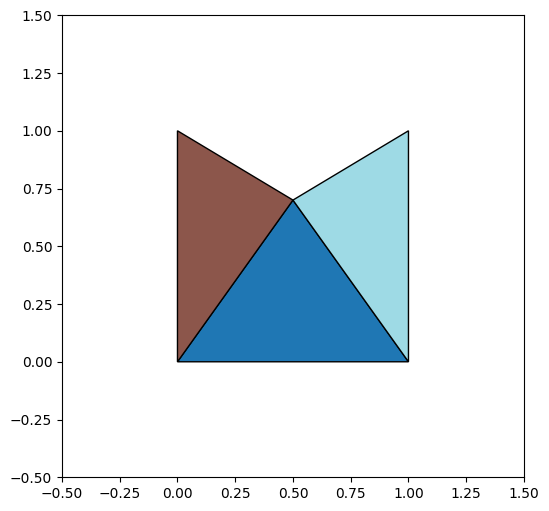

In [114]:
points = np.array([[0, 0], [1, 0], [1, 1], [0.5, 0.7], [0, 1]])
triangulator1 = Delone_with_cash2()

for point in points:
    triangulator1.add_point(tuple(point))
    print(triangulator1.points)

for tri in triangulator1.triangles:
    print("Треугольник:", tri)

triangles2 = triangulator1.triangles
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.show()

Треугольник: ((0.6118016059199116, 0.041785810737190794), (0.7030396452005186, 0.2898329394816675), (0.43112943173078716, 0.429819076182329))
Треугольник: ((0.6118016059199116, 0.041785810737190794), (0.43112943173078716, 0.429819076182329), (0.48235357058686784, -0.3293442650161905))
Треугольник: ((0.7030396452005186, 0.2898329394816675), (0.7174640179081649, 0.4137364352321612), (0.43112943173078716, 0.429819076182329))
Треугольник: ((0.43112943173078716, 0.429819076182329), (0.41728785103854493, 0.7273922670110726), (0.30773142597751313, 0.6083700607274468))
Треугольник: ((0.43112943173078716, 0.429819076182329), (0.30773142597751313, 0.6083700607274468), (-0.24771490606724395, 0.5069934338757739))
Треугольник: ((0.43112943173078716, 0.429819076182329), (-0.24771490606724395, 0.5069934338757739), (0.48235357058686784, -0.3293442650161905))
Треугольник: ((0.30773142597751313, 0.6083700607274468), (0.15207819101646056, 0.8401125809565557), (-0.24771490606724395, 0.5069934338757739))
Т

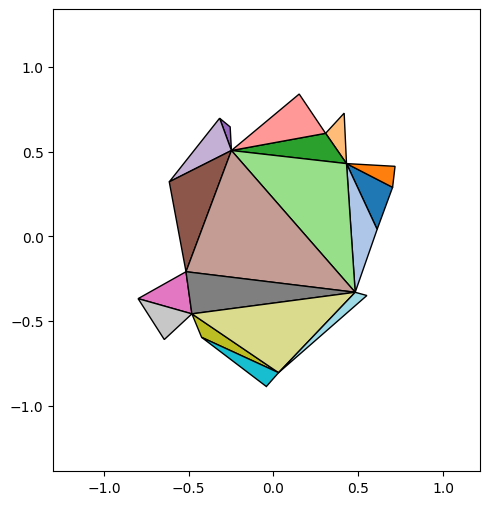

In [115]:
triangulator2 = Delone_with_cash2()

for point in random_polygon:
    triangulator2.add_point(tuple(point))
    # print(triangulator2.points)
for tri in triangulator2.triangles:
    print("Треугольник:", tri)

triangles2 = triangulator2.triangles
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)
plt.show()

In [121]:
triangulator2.cache, triangulator2.cache_bounds, triangulator2.cache_size

([(0.6118016059199116, 0.041785810737190794)],
 [-1.3881983940800884,
  -1.958214189262809,
  2.6118016059199114,
  2.0417858107371907],
 2)

In [123]:
triangulator1.cache, triangulator1.cache_bounds, triangulator1.cache_size

([(0.0, 0.0)], [-2.0, -2.0, 2.0, 2.0], 2)